In [3]:
# Reinforcment Learning - Maze Game
# https://www.samyzaf.com/ML/rl/qmaze.html
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
# install Sequential library
# python m pip install --upgrade Sequential  
from keras.models import Sequential  
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
    [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.]
])

In [5]:
# Cells visited by the rat will be painted by gray 0.8
visited_mark = 0.8 
# The current rat cell will be painteg by gray 0.5
rat_mark = 0.5      
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


In [6]:
# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

In [7]:
num_actions = len(actions_dict)

In [8]:
# Exploration factor
epsilon = 0.1

In [13]:
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self,maze,rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" 
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)
        
    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()
            
    def update_state(self,action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state
        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()
        
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)
                
    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04        
        
    def act(self,action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status
    
    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate
    
    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas    
    
    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'
    
    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)
        return actions

In [14]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [15]:
maze = [
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
]

reward= -0.04


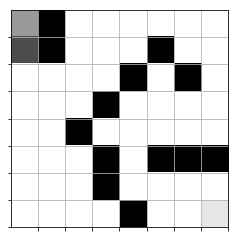

In [22]:
qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

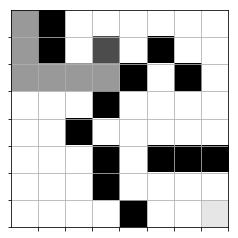

In [23]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

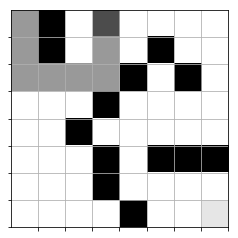

In [24]:
qmaze.act(UP)  # move up
show(qmaze)

In [27]:
# model - a trained neural network which calculates the next action
# qmaze - A Qmaze object
# rat_cell - the starting cell of the rat
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [26]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [29]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

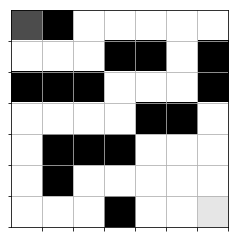

In [30]:
maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

qmaze = Qmaze(maze)
show(qmaze)

In [39]:
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [38]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [40]:
model = build_model(maze)

In [41]:
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch: 000/14999 | Loss: 0.0311 | Episodes: 105 | Win count: 0 | Win rate: 0.000 | time: 26.1 seconds
Epoch: 001/14999 | Loss: 0.0009 | Episodes: 104 | Win count: 0 | Win rate: 0.000 | time: 50.0 seconds
Epoch: 002/14999 | Loss: 0.0013 | Episodes: 106 | Win count: 0 | Win rate: 0.000 | time: 73.9 seconds
Epoch: 003/14999 | Loss: 0.0011 | Episodes: 68 | Win count: 1 | Win rate: 0.000 | time: 89.5 seconds
Epoch: 004/14999 | Loss: 0.0558 | Episodes: 63 | Win count: 2 | Win rate: 0.000 | time: 103.7 seconds
Epoch: 005/14999 | Loss: 0.0024 | Episodes: 102 | Win count: 2 | Win rate: 0.000 | time: 126.8 seconds
Epoch: 006/14999 | Loss: 0.0082 | Episodes: 18 | Win count: 3 | Win rate: 0.000 | time: 130.9 seconds
Epoch: 007/14999 | Loss: 0.0046 | Episodes: 104 | Win count: 3 | Win rate: 0.000 | time: 154.5 seconds
Epoch: 008/14999 | Loss: 0.0081 | Episodes: 109 | Win count: 3 | Win rate: 0.000 | time: 179.0 seconds
Epoch: 009/14999 | Loss: 0.0014 

421.433146

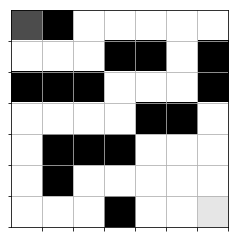

In [55]:
maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

qmaze = Qmaze(maze)
show(qmaze)

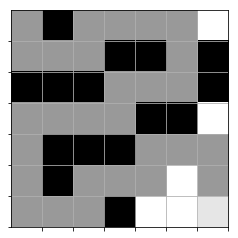

In [56]:
play_game(model, qmaze, (0,0))
show(qmaze)

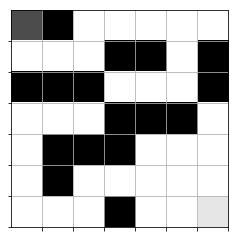

In [65]:
# test Selina Maze
maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  0.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

qmaze = Qmaze(maze)
show(qmaze)

In [66]:
model = build_model(maze)

In [ ]:
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Loss: 0.0024 | Episodes: 61 | Win count: 1 | Win rate: 0.000 | time: 7.0 seconds
Epoch: 001/14999 | Loss: 0.0074 | Episodes: 104 | Win count: 1 | Win rate: 0.000 | time: 17.2 seconds
Epoch: 002/14999 | Loss: 0.0097 | Episodes: 5 | Win count: 2 | Win rate: 0.000 | time: 17.7 seconds
Epoch: 003/14999 | Loss: 0.0054 | Episodes: 44 | Win count: 3 | Win rate: 0.000 | time: 21.9 seconds
Epoch: 004/14999 | Loss: 0.0042 | Episodes: 102 | Win count: 3 | Win rate: 0.000 | time: 33.2 seconds
Epoch: 005/14999 | Loss: 0.0053 | Episodes: 104 | Win count: 3 | Win rate: 0.000 | time: 45.1 seconds
Epoch: 006/14999 | Loss: 0.0043 | Episodes: 5 | Win count: 4 | Win rate: 0.000 | time: 45.7 seconds
Epoch: 007/14999 | Loss: 0.0021 | Episodes: 102 | Win count: 4 | Win rate: 0.000 | time: 57.3 seconds
Epoch: 008/14999 | Loss: 0.0028 | Episodes: 104 | Win count: 4 | Win rate: 0.000 | time: 69.1 seconds
Epoch: 009/14999 | Loss: 0.0013 | Episodes: 4 | Win count: 5 | Win rate: 0.000 | time: 69

Epoch: 080/14999 | Loss: 0.0015 | Episodes: 101 | Win count: 41 | Win rate: 0.667 | time: 9.75 minutes
Epoch: 081/14999 | Loss: 0.0021 | Episodes: 7 | Win count: 42 | Win rate: 0.667 | time: 9.77 minutes
Epoch: 082/14999 | Loss: 0.0005 | Episodes: 10 | Win count: 43 | Win rate: 0.667 | time: 9.79 minutes
Epoch: 083/14999 | Loss: 0.0561 | Episodes: 3 | Win count: 44 | Win rate: 0.667 | time: 9.80 minutes
Epoch: 084/14999 | Loss: 0.0533 | Episodes: 2 | Win count: 45 | Win rate: 0.708 | time: 9.80 minutes
Epoch: 085/14999 | Loss: 0.0011 | Episodes: 106 | Win count: 45 | Win rate: 0.667 | time: 10.03 minutes
Epoch: 086/14999 | Loss: 0.0051 | Episodes: 16 | Win count: 46 | Win rate: 0.667 | time: 10.07 minutes
Epoch: 087/14999 | Loss: 0.0021 | Episodes: 1 | Win count: 47 | Win rate: 0.708 | time: 10.07 minutes
Epoch: 088/14999 | Loss: 0.0071 | Episodes: 104 | Win count: 47 | Win rate: 0.667 | time: 10.30 minutes
Epoch: 089/14999 | Loss: 0.0027 | Episodes: 71 | Win count: 48 | Win rate: 0.66

Epoch: 160/14999 | Loss: 0.0021 | Episodes: 15 | Win count: 83 | Win rate: 0.542 | time: 19.92 minutes
Epoch: 161/14999 | Loss: 0.0010 | Episodes: 104 | Win count: 83 | Win rate: 0.542 | time: 20.17 minutes
Epoch: 162/14999 | Loss: 0.0018 | Episodes: 1 | Win count: 84 | Win rate: 0.583 | time: 20.17 minutes
Epoch: 163/14999 | Loss: 0.0602 | Episodes: 104 | Win count: 84 | Win rate: 0.583 | time: 20.40 minutes
Epoch: 164/14999 | Loss: 0.0018 | Episodes: 2 | Win count: 85 | Win rate: 0.625 | time: 20.41 minutes
Epoch: 165/14999 | Loss: 0.0651 | Episodes: 12 | Win count: 86 | Win rate: 0.667 | time: 20.44 minutes
Epoch: 166/14999 | Loss: 0.0030 | Episodes: 108 | Win count: 86 | Win rate: 0.625 | time: 20.69 minutes
Epoch: 167/14999 | Loss: 0.0019 | Episodes: 2 | Win count: 87 | Win rate: 0.667 | time: 20.69 minutes
Epoch: 168/14999 | Loss: 0.0005 | Episodes: 105 | Win count: 87 | Win rate: 0.625 | time: 20.93 minutes
Epoch: 169/14999 | Loss: 0.0026 | Episodes: 103 | Win count: 87 | Win ra

Epoch: 239/14999 | Loss: 0.0653 | Episodes: 15 | Win count: 126 | Win rate: 0.500 | time: 29.56 minutes
Epoch: 240/14999 | Loss: 0.0016 | Episodes: 104 | Win count: 126 | Win rate: 0.500 | time: 29.80 minutes
Epoch: 241/14999 | Loss: 0.0021 | Episodes: 2 | Win count: 127 | Win rate: 0.542 | time: 29.81 minutes
Epoch: 242/14999 | Loss: 0.0047 | Episodes: 104 | Win count: 127 | Win rate: 0.500 | time: 30.06 minutes
Epoch: 243/14999 | Loss: 0.0018 | Episodes: 3 | Win count: 128 | Win rate: 0.542 | time: 30.06 minutes
Epoch: 244/14999 | Loss: 0.0012 | Episodes: 3 | Win count: 129 | Win rate: 0.542 | time: 30.07 minutes
Epoch: 245/14999 | Loss: 0.1248 | Episodes: 105 | Win count: 129 | Win rate: 0.542 | time: 30.32 minutes
Epoch: 246/14999 | Loss: 0.0017 | Episodes: 13 | Win count: 130 | Win rate: 0.583 | time: 30.35 minutes
Epoch: 247/14999 | Loss: 0.0007 | Episodes: 3 | Win count: 131 | Win rate: 0.583 | time: 30.36 minutes
Epoch: 248/14999 | Loss: 0.0013 | Episodes: 8 | Win count: 132 | 

Epoch: 318/14999 | Loss: 0.0046 | Episodes: 2 | Win count: 177 | Win rate: 0.583 | time: 37.12 minutes
Epoch: 319/14999 | Loss: 0.0338 | Episodes: 103 | Win count: 177 | Win rate: 0.583 | time: 37.36 minutes
Epoch: 320/14999 | Loss: 0.0316 | Episodes: 11 | Win count: 178 | Win rate: 0.625 | time: 37.39 minutes
Epoch: 321/14999 | Loss: 0.0039 | Episodes: 2 | Win count: 179 | Win rate: 0.625 | time: 37.39 minutes
Epoch: 322/14999 | Loss: 0.0021 | Episodes: 104 | Win count: 179 | Win rate: 0.625 | time: 37.64 minutes
Epoch: 323/14999 | Loss: 0.1064 | Episodes: 9 | Win count: 180 | Win rate: 0.667 | time: 37.66 minutes
Epoch: 324/14999 | Loss: 0.0027 | Episodes: 5 | Win count: 181 | Win rate: 0.667 | time: 37.67 minutes
Epoch: 325/14999 | Loss: 0.0008 | Episodes: 102 | Win count: 181 | Win rate: 0.667 | time: 37.91 minutes
Epoch: 326/14999 | Loss: 0.0651 | Episodes: 102 | Win count: 181 | Win rate: 0.625 | time: 38.15 minutes
Epoch: 327/14999 | Loss: 0.0006 | Episodes: 8 | Win count: 182 |

Epoch: 397/14999 | Loss: 0.0182 | Episodes: 3 | Win count: 222 | Win rate: 0.542 | time: 46.17 minutes
Epoch: 398/14999 | Loss: 0.0026 | Episodes: 105 | Win count: 222 | Win rate: 0.542 | time: 46.41 minutes
Epoch: 399/14999 | Loss: 0.0293 | Episodes: 1 | Win count: 223 | Win rate: 0.542 | time: 46.41 minutes
Epoch: 400/14999 | Loss: 0.0019 | Episodes: 8 | Win count: 224 | Win rate: 0.583 | time: 46.43 minutes
Epoch: 401/14999 | Loss: 0.0654 | Episodes: 104 | Win count: 224 | Win rate: 0.542 | time: 46.66 minutes
Epoch: 402/14999 | Loss: 0.0023 | Episodes: 103 | Win count: 224 | Win rate: 0.500 | time: 46.89 minutes
Epoch: 403/14999 | Loss: 0.1783 | Episodes: 2 | Win count: 225 | Win rate: 0.542 | time: 46.90 minutes
Epoch: 404/14999 | Loss: 0.0054 | Episodes: 1 | Win count: 226 | Win rate: 0.542 | time: 46.90 minutes
Epoch: 405/14999 | Loss: 0.0051 | Episodes: 6 | Win count: 227 | Win rate: 0.583 | time: 46.91 minutes
Epoch: 406/14999 | Loss: 0.0017 | Episodes: 103 | Win count: 227 | 

Epoch: 476/14999 | Loss: 0.0026 | Episodes: 3 | Win count: 269 | Win rate: 0.708 | time: 54.63 minutes
Epoch: 477/14999 | Loss: 0.0012 | Episodes: 6 | Win count: 270 | Win rate: 0.708 | time: 54.65 minutes
Epoch: 478/14999 | Loss: 0.0404 | Episodes: 106 | Win count: 270 | Win rate: 0.708 | time: 54.89 minutes
Epoch: 479/14999 | Loss: 0.0740 | Episodes: 104 | Win count: 270 | Win rate: 0.708 | time: 55.14 minutes
Epoch: 480/14999 | Loss: 0.0021 | Episodes: 9 | Win count: 271 | Win rate: 0.708 | time: 55.16 minutes
Epoch: 481/14999 | Loss: 0.0014 | Episodes: 12 | Win count: 272 | Win rate: 0.708 | time: 55.18 minutes
Epoch: 482/14999 | Loss: 0.0020 | Episodes: 9 | Win count: 273 | Win rate: 0.750 | time: 55.21 minutes
Epoch: 483/14999 | Loss: 0.0011 | Episodes: 102 | Win count: 273 | Win rate: 0.708 | time: 55.45 minutes
Epoch: 484/14999 | Loss: 0.0011 | Episodes: 5 | Win count: 274 | Win rate: 0.708 | time: 55.46 minutes
Epoch: 485/14999 | Loss: 0.0529 | Episodes: 1 | Win count: 275 | W

Epoch: 556/14999 | Loss: 0.0289 | Episodes: 9 | Win count: 317 | Win rate: 0.667 | time: 1.20 hours
Epoch: 557/14999 | Loss: 0.0504 | Episodes: 11 | Win count: 318 | Win rate: 0.708 | time: 1.20 hours
Epoch: 558/14999 | Loss: 0.0012 | Episodes: 2 | Win count: 319 | Win rate: 0.750 | time: 1.20 hours
Epoch: 559/14999 | Loss: 0.0005 | Episodes: 103 | Win count: 319 | Win rate: 0.750 | time: 1.20 hours
Epoch: 560/14999 | Loss: 0.0522 | Episodes: 4 | Win count: 320 | Win rate: 0.750 | time: 1.20 hours
Epoch: 561/14999 | Loss: 0.0021 | Episodes: 105 | Win count: 320 | Win rate: 0.750 | time: 1.21 hours
Epoch: 562/14999 | Loss: 0.0021 | Episodes: 6 | Win count: 321 | Win rate: 0.792 | time: 1.21 hours
Epoch: 563/14999 | Loss: 0.0011 | Episodes: 2 | Win count: 322 | Win rate: 0.792 | time: 1.21 hours
Epoch: 564/14999 | Loss: 0.0009 | Episodes: 2 | Win count: 323 | Win rate: 0.833 | time: 1.21 hours
Epoch: 565/14999 | Loss: 0.0009 | Episodes: 1 | Win count: 324 | Win rate: 0.833 | time: 1.21 h

Epoch: 638/14999 | Loss: 0.0024 | Episodes: 104 | Win count: 367 | Win rate: 0.667 | time: 1.34 hours
Epoch: 639/14999 | Loss: 0.0586 | Episodes: 1 | Win count: 368 | Win rate: 0.667 | time: 1.34 hours
Epoch: 640/14999 | Loss: 0.0013 | Episodes: 104 | Win count: 368 | Win rate: 0.625 | time: 1.34 hours
Epoch: 641/14999 | Loss: 0.0039 | Episodes: 13 | Win count: 369 | Win rate: 0.667 | time: 1.34 hours
Epoch: 642/14999 | Loss: 0.0427 | Episodes: 104 | Win count: 369 | Win rate: 0.625 | time: 1.35 hours
Epoch: 643/14999 | Loss: 0.0042 | Episodes: 12 | Win count: 370 | Win rate: 0.667 | time: 1.35 hours
Epoch: 644/14999 | Loss: 0.0476 | Episodes: 2 | Win count: 371 | Win rate: 0.667 | time: 1.35 hours
Epoch: 645/14999 | Loss: 0.0026 | Episodes: 3 | Win count: 372 | Win rate: 0.708 | time: 1.35 hours
Epoch: 646/14999 | Loss: 0.0020 | Episodes: 5 | Win count: 373 | Win rate: 0.750 | time: 1.35 hours
Epoch: 647/14999 | Loss: 0.0011 | Episodes: 104 | Win count: 373 | Win rate: 0.708 | time: 1

Epoch: 720/14999 | Loss: 0.0008 | Episodes: 102 | Win count: 428 | Win rate: 0.708 | time: 1.45 hours
Epoch: 721/14999 | Loss: 0.0020 | Episodes: 9 | Win count: 429 | Win rate: 0.708 | time: 1.45 hours
Epoch: 722/14999 | Loss: 0.0016 | Episodes: 104 | Win count: 429 | Win rate: 0.667 | time: 1.45 hours
Epoch: 723/14999 | Loss: 0.0017 | Episodes: 104 | Win count: 429 | Win rate: 0.625 | time: 1.46 hours
Epoch: 724/14999 | Loss: 0.0048 | Episodes: 105 | Win count: 429 | Win rate: 0.583 | time: 1.46 hours
Epoch: 725/14999 | Loss: 0.0019 | Episodes: 104 | Win count: 429 | Win rate: 0.542 | time: 1.47 hours
Epoch: 726/14999 | Loss: 0.0018 | Episodes: 104 | Win count: 429 | Win rate: 0.500 | time: 1.47 hours
Epoch: 727/14999 | Loss: 0.0552 | Episodes: 10 | Win count: 430 | Win rate: 0.500 | time: 1.47 hours
Epoch: 728/14999 | Loss: 0.0056 | Episodes: 4 | Win count: 431 | Win rate: 0.500 | time: 1.47 hours
Epoch: 729/14999 | Loss: 0.0028 | Episodes: 1 | Win count: 432 | Win rate: 0.500 | time

Epoch: 802/14999 | Loss: 0.0409 | Episodes: 5 | Win count: 471 | Win rate: 0.583 | time: 1.65 hours
Epoch: 803/14999 | Loss: 0.0129 | Episodes: 2 | Win count: 472 | Win rate: 0.583 | time: 1.65 hours
Epoch: 804/14999 | Loss: 0.0055 | Episodes: 5 | Win count: 473 | Win rate: 0.583 | time: 1.65 hours
Epoch: 805/14999 | Loss: 0.0061 | Episodes: 2 | Win count: 474 | Win rate: 0.583 | time: 1.65 hours
Epoch: 806/14999 | Loss: 0.0008 | Episodes: 13 | Win count: 475 | Win rate: 0.583 | time: 1.65 hours
Epoch: 807/14999 | Loss: 0.0023 | Episodes: 1 | Win count: 476 | Win rate: 0.583 | time: 1.65 hours
Epoch: 808/14999 | Loss: 0.0010 | Episodes: 104 | Win count: 476 | Win rate: 0.583 | time: 1.65 hours
Epoch: 809/14999 | Loss: 0.0560 | Episodes: 4 | Win count: 477 | Win rate: 0.625 | time: 1.65 hours
Epoch: 810/14999 | Loss: 0.0014 | Episodes: 9 | Win count: 478 | Win rate: 0.625 | time: 1.65 hours
Epoch: 811/14999 | Loss: 0.0027 | Episodes: 13 | Win count: 479 | Win rate: 0.667 | time: 1.65 ho

Epoch: 884/14999 | Loss: 0.0013 | Episodes: 3 | Win count: 526 | Win rate: 0.667 | time: 1.80 hours
Epoch: 885/14999 | Loss: 0.0015 | Episodes: 5 | Win count: 527 | Win rate: 0.667 | time: 1.80 hours
Epoch: 886/14999 | Loss: 0.0043 | Episodes: 108 | Win count: 527 | Win rate: 0.625 | time: 1.80 hours
Epoch: 887/14999 | Loss: 0.0010 | Episodes: 9 | Win count: 528 | Win rate: 0.625 | time: 1.80 hours
Epoch: 888/14999 | Loss: 0.0030 | Episodes: 103 | Win count: 528 | Win rate: 0.583 | time: 1.81 hours
Epoch: 889/14999 | Loss: 0.0052 | Episodes: 106 | Win count: 528 | Win rate: 0.583 | time: 1.81 hours
Epoch: 890/14999 | Loss: 0.0026 | Episodes: 102 | Win count: 528 | Win rate: 0.583 | time: 1.82 hours
Epoch: 891/14999 | Loss: 0.0013 | Episodes: 2 | Win count: 529 | Win rate: 0.583 | time: 1.82 hours
Epoch: 892/14999 | Loss: 0.0639 | Episodes: 7 | Win count: 530 | Win rate: 0.583 | time: 1.82 hours
Epoch: 893/14999 | Loss: 0.0020 | Episodes: 5 | Win count: 531 | Win rate: 0.625 | time: 1.8

Epoch: 966/14999 | Loss: 0.1250 | Episodes: 4 | Win count: 577 | Win rate: 0.708 | time: 1.96 hours
Epoch: 967/14999 | Loss: 0.0014 | Episodes: 10 | Win count: 578 | Win rate: 0.708 | time: 1.96 hours
Epoch: 968/14999 | Loss: 0.0005 | Episodes: 106 | Win count: 578 | Win rate: 0.667 | time: 1.97 hours
Epoch: 969/14999 | Loss: 0.0006 | Episodes: 3 | Win count: 579 | Win rate: 0.667 | time: 1.97 hours
Epoch: 970/14999 | Loss: 0.0038 | Episodes: 10 | Win count: 580 | Win rate: 0.667 | time: 1.97 hours
Epoch: 971/14999 | Loss: 0.0849 | Episodes: 11 | Win count: 581 | Win rate: 0.667 | time: 1.97 hours
Epoch: 972/14999 | Loss: 0.0090 | Episodes: 1 | Win count: 582 | Win rate: 0.667 | time: 1.97 hours
Epoch: 973/14999 | Loss: 0.0130 | Episodes: 10 | Win count: 583 | Win rate: 0.708 | time: 1.97 hours
Epoch: 974/14999 | Loss: 0.0014 | Episodes: 101 | Win count: 583 | Win rate: 0.708 | time: 1.97 hours
Epoch: 975/14999 | Loss: 0.0020 | Episodes: 101 | Win count: 583 | Win rate: 0.667 | time: 1

Epoch: 1048/14999 | Loss: 0.0012 | Episodes: 102 | Win count: 628 | Win rate: 0.500 | time: 2.13 hours
Epoch: 1049/14999 | Loss: 0.0012 | Episodes: 99 | Win count: 628 | Win rate: 0.500 | time: 2.14 hours
Epoch: 1050/14999 | Loss: 0.0542 | Episodes: 40 | Win count: 629 | Win rate: 0.542 | time: 2.14 hours
Epoch: 1051/14999 | Loss: 0.1143 | Episodes: 102 | Win count: 629 | Win rate: 0.542 | time: 2.15 hours
Epoch: 1052/14999 | Loss: 0.0012 | Episodes: 9 | Win count: 630 | Win rate: 0.542 | time: 2.15 hours
Epoch: 1053/14999 | Loss: 0.1175 | Episodes: 4 | Win count: 631 | Win rate: 0.542 | time: 2.15 hours
Epoch: 1054/14999 | Loss: 0.0008 | Episodes: 12 | Win count: 632 | Win rate: 0.542 | time: 2.15 hours
Epoch: 1055/14999 | Loss: 0.0598 | Episodes: 2 | Win count: 633 | Win rate: 0.542 | time: 2.15 hours
Epoch: 1056/14999 | Loss: 0.0019 | Episodes: 6 | Win count: 634 | Win rate: 0.583 | time: 2.15 hours
Epoch: 1057/14999 | Loss: 0.0013 | Episodes: 4 | Win count: 635 | Win rate: 0.625 | 

Epoch: 1128/14999 | Loss: 0.0036 | Episodes: 1 | Win count: 675 | Win rate: 0.542 | time: 2.31 hours
Epoch: 1129/14999 | Loss: 0.0021 | Episodes: 23 | Win count: 676 | Win rate: 0.542 | time: 2.32 hours
Epoch: 1130/14999 | Loss: 0.0016 | Episodes: 101 | Win count: 676 | Win rate: 0.500 | time: 2.32 hours
Epoch: 1131/14999 | Loss: 0.0453 | Episodes: 102 | Win count: 676 | Win rate: 0.500 | time: 2.32 hours
Epoch: 1132/14999 | Loss: 0.0028 | Episodes: 106 | Win count: 676 | Win rate: 0.458 | time: 2.33 hours
Epoch: 1133/14999 | Loss: 0.0014 | Episodes: 1 | Win count: 677 | Win rate: 0.500 | time: 2.33 hours
Epoch: 1134/14999 | Loss: 0.0034 | Episodes: 106 | Win count: 677 | Win rate: 0.458 | time: 2.33 hours
Epoch: 1135/14999 | Loss: 0.0021 | Episodes: 1 | Win count: 678 | Win rate: 0.500 | time: 2.33 hours
Epoch: 1136/14999 | Loss: 0.0009 | Episodes: 6 | Win count: 679 | Win rate: 0.542 | time: 2.33 hours
Epoch: 1137/14999 | Loss: 0.0371 | Episodes: 8 | Win count: 680 | Win rate: 0.542 

Epoch: 1209/14999 | Loss: 0.0019 | Episodes: 5 | Win count: 718 | Win rate: 0.625 | time: 2.52 hours
Epoch: 1210/14999 | Loss: 0.0011 | Episodes: 8 | Win count: 719 | Win rate: 0.667 | time: 2.52 hours
Epoch: 1211/14999 | Loss: 0.0735 | Episodes: 102 | Win count: 719 | Win rate: 0.625 | time: 2.52 hours
Epoch: 1212/14999 | Loss: 0.0016 | Episodes: 15 | Win count: 720 | Win rate: 0.667 | time: 2.52 hours
Epoch: 1213/14999 | Loss: 0.0018 | Episodes: 10 | Win count: 721 | Win rate: 0.708 | time: 2.53 hours
Epoch: 1214/14999 | Loss: 0.0007 | Episodes: 104 | Win count: 721 | Win rate: 0.708 | time: 2.53 hours
Epoch: 1215/14999 | Loss: 0.0022 | Episodes: 3 | Win count: 722 | Win rate: 0.750 | time: 2.53 hours
Epoch: 1216/14999 | Loss: 0.0008 | Episodes: 5 | Win count: 723 | Win rate: 0.750 | time: 2.53 hours
Epoch: 1217/14999 | Loss: 0.0011 | Episodes: 104 | Win count: 723 | Win rate: 0.708 | time: 2.54 hours
Epoch: 1218/14999 | Loss: 0.0021 | Episodes: 104 | Win count: 723 | Win rate: 0.667

Epoch: 1290/14999 | Loss: 0.0018 | Episodes: 4 | Win count: 764 | Win rate: 0.792 | time: 2.71 hours
Epoch: 1291/14999 | Loss: 0.0039 | Episodes: 105 | Win count: 764 | Win rate: 0.750 | time: 2.72 hours
Epoch: 1292/14999 | Loss: 0.0237 | Episodes: 101 | Win count: 764 | Win rate: 0.750 | time: 2.72 hours
Epoch: 1293/14999 | Loss: 0.0045 | Episodes: 8 | Win count: 765 | Win rate: 0.750 | time: 2.72 hours
Epoch: 1294/14999 | Loss: 0.0018 | Episodes: 7 | Win count: 766 | Win rate: 0.750 | time: 2.72 hours
Epoch: 1295/14999 | Loss: 0.0017 | Episodes: 7 | Win count: 767 | Win rate: 0.750 | time: 2.72 hours
Epoch: 1296/14999 | Loss: 0.0013 | Episodes: 108 | Win count: 767 | Win rate: 0.708 | time: 2.73 hours
Epoch: 1297/14999 | Loss: 0.0441 | Episodes: 103 | Win count: 767 | Win rate: 0.667 | time: 2.73 hours
Epoch: 1298/14999 | Loss: 0.0235 | Episodes: 104 | Win count: 767 | Win rate: 0.625 | time: 2.74 hours
Epoch: 1299/14999 | Loss: 0.0014 | Episodes: 3 | Win count: 768 | Win rate: 0.625

Epoch: 1371/14999 | Loss: 0.0017 | Episodes: 2 | Win count: 813 | Win rate: 0.667 | time: 2.90 hours
Epoch: 1372/14999 | Loss: 0.0005 | Episodes: 10 | Win count: 814 | Win rate: 0.708 | time: 2.90 hours
Epoch: 1373/14999 | Loss: 0.0010 | Episodes: 103 | Win count: 814 | Win rate: 0.667 | time: 2.91 hours
Epoch: 1374/14999 | Loss: 0.0014 | Episodes: 4 | Win count: 815 | Win rate: 0.708 | time: 2.91 hours
Epoch: 1375/14999 | Loss: 0.0004 | Episodes: 3 | Win count: 816 | Win rate: 0.708 | time: 2.91 hours
Epoch: 1376/14999 | Loss: 0.0016 | Episodes: 105 | Win count: 816 | Win rate: 0.667 | time: 2.91 hours
Epoch: 1377/14999 | Loss: 0.0009 | Episodes: 12 | Win count: 817 | Win rate: 0.667 | time: 2.91 hours
Epoch: 1378/14999 | Loss: 0.0007 | Episodes: 14 | Win count: 818 | Win rate: 0.667 | time: 2.91 hours
Epoch: 1379/14999 | Loss: 0.0016 | Episodes: 2 | Win count: 819 | Win rate: 0.667 | time: 2.91 hours
Epoch: 1380/14999 | Loss: 0.0020 | Episodes: 6 | Win count: 820 | Win rate: 0.708 | 

Epoch: 1452/14999 | Loss: 0.0031 | Episodes: 3 | Win count: 868 | Win rate: 0.625 | time: 3.05 hours
Epoch: 1453/14999 | Loss: 0.0038 | Episodes: 11 | Win count: 869 | Win rate: 0.667 | time: 3.05 hours
Epoch: 1454/14999 | Loss: 0.0023 | Episodes: 4 | Win count: 870 | Win rate: 0.708 | time: 3.05 hours
Epoch: 1455/14999 | Loss: 0.0012 | Episodes: 106 | Win count: 870 | Win rate: 0.708 | time: 3.06 hours
Epoch: 1456/14999 | Loss: 0.0371 | Episodes: 14 | Win count: 871 | Win rate: 0.708 | time: 3.06 hours
Epoch: 1457/14999 | Loss: 0.0046 | Episodes: 12 | Win count: 872 | Win rate: 0.708 | time: 3.06 hours
Epoch: 1458/14999 | Loss: 0.0020 | Episodes: 104 | Win count: 872 | Win rate: 0.667 | time: 3.06 hours
Epoch: 1459/14999 | Loss: 0.0253 | Episodes: 29 | Win count: 873 | Win rate: 0.667 | time: 3.07 hours
Epoch: 1460/14999 | Loss: 0.0511 | Episodes: 103 | Win count: 873 | Win rate: 0.625 | time: 3.07 hours
Epoch: 1461/14999 | Loss: 0.0280 | Episodes: 105 | Win count: 873 | Win rate: 0.5

Epoch: 1533/14999 | Loss: 0.0462 | Episodes: 109 | Win count: 918 | Win rate: 0.750 | time: 3.23 hours
Epoch: 1534/14999 | Loss: 0.0016 | Episodes: 2 | Win count: 919 | Win rate: 0.750 | time: 3.23 hours
Epoch: 1535/14999 | Loss: 0.0007 | Episodes: 99 | Win count: 919 | Win rate: 0.708 | time: 3.23 hours
Epoch: 1536/14999 | Loss: 0.0437 | Episodes: 3 | Win count: 920 | Win rate: 0.708 | time: 3.23 hours
Epoch: 1537/14999 | Loss: 0.0563 | Episodes: 11 | Win count: 921 | Win rate: 0.708 | time: 3.23 hours
Epoch: 1538/14999 | Loss: 0.0009 | Episodes: 5 | Win count: 922 | Win rate: 0.708 | time: 3.23 hours
Epoch: 1539/14999 | Loss: 0.0436 | Episodes: 104 | Win count: 922 | Win rate: 0.667 | time: 3.24 hours
Epoch: 1540/14999 | Loss: 0.0009 | Episodes: 7 | Win count: 923 | Win rate: 0.667 | time: 3.24 hours
Epoch: 1541/14999 | Loss: 0.0026 | Episodes: 102 | Win count: 923 | Win rate: 0.625 | time: 3.24 hours
Epoch: 1542/14999 | Loss: 0.0009 | Episodes: 10 | Win count: 924 | Win rate: 0.625 

Epoch: 1614/14999 | Loss: 0.0008 | Episodes: 11 | Win count: 966 | Win rate: 0.458 | time: 3.41 hours
Epoch: 1615/14999 | Loss: 0.0008 | Episodes: 2 | Win count: 967 | Win rate: 0.500 | time: 3.41 hours
Epoch: 1616/14999 | Loss: 0.0521 | Episodes: 9 | Win count: 968 | Win rate: 0.542 | time: 3.41 hours
Epoch: 1617/14999 | Loss: 0.0017 | Episodes: 17 | Win count: 969 | Win rate: 0.542 | time: 3.41 hours
Epoch: 1618/14999 | Loss: 0.0012 | Episodes: 2 | Win count: 970 | Win rate: 0.542 | time: 3.41 hours
Epoch: 1619/14999 | Loss: 0.0466 | Episodes: 3 | Win count: 971 | Win rate: 0.583 | time: 3.41 hours
Epoch: 1620/14999 | Loss: 0.0014 | Episodes: 4 | Win count: 972 | Win rate: 0.625 | time: 3.41 hours
Epoch: 1621/14999 | Loss: 0.0010 | Episodes: 104 | Win count: 972 | Win rate: 0.625 | time: 3.42 hours
Epoch: 1622/14999 | Loss: 0.0012 | Episodes: 16 | Win count: 973 | Win rate: 0.625 | time: 3.42 hours
Epoch: 1623/14999 | Loss: 0.0032 | Episodes: 4 | Win count: 974 | Win rate: 0.667 | ti